In [18]:
import esda
import os
import osmnx as ox
import numpy as np
import pandas as pd
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran
import geopandas as gpd
import spaghetti as spt
import matplotlib.pyplot as plt 
from pyproj import CRS, Transformer
from shapely.geometry import Polygon, Point, LineString
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import networkx as nx

In [7]:
# read data sets
DATA_PATH = "E:/KCL/Network data analysis/coursework2/Coursework_2/data_NDA/"
FILE_NAMES = [ "2015.csv", "2016.csv", "2017.csv", "2018.csv", "2019.csv"]

In [8]:
# Use the Grid reference: Northing and Easting in the data
USE_COLS = [1,2]
# Read in the accident data from 2009 to 2019 as a Pandas DataFrame
all_accidents = pd.DataFrame(columns=['Easting', 'Northing'])
for FILE_NAME in FILE_NAMES:
    accidents = pd.read_csv (DATA_PATH+FILE_NAME, delimiter = ",",  header=0, names=['Easting', 'Northing'], usecols = USE_COLS)
    all_accidents=pd.concat([all_accidents, accidents])
# Some crimes do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_accidents= all_accidents.dropna (subset = ['Easting', 'Northing'])
located_accidents.head()

,Easting,Northing
0,427798,426248
1,427798,426248
2,431142,430087
3,434602,436699
4,434254,434318


In [9]:
os.environ['PROJ_NETWORK'] = 'OFF'
# transform from the British National Grid to the WGS84
def transformBNG2WGS84(East, North):
    crs_british = CRS.from_epsg(27700) # British national grid
    crs_wgs84 = CRS.from_epsg(4326) # WGS84
    transformer = Transformer.from_crs(crs_british, crs_wgs84)
    xx, yy = transformer.transform(East, North)
    return xx, yy
located_accidents.Easting, located_accidents.Northing = transformBNG2WGS84(located_accidents.Easting, located_accidents.Northing)
located_accidents=located_accidents.rename(columns = {"Easting": "Latitude", "Northing":"Longitude"})

In [10]:
# Transform to a GeoDatFrame where the geometry is given by a Point constructed from the longitude and latitude
accidents_points = gpd.GeoDataFrame (geometry = [Point(xy) for xy in zip (located_accidents['Longitude'], located_accidents['Latitude'])])
accidents_points.head()

,geometry
0,POINT (-1.58012 53.73189)
1,POINT (-1.58012 53.73189)
2,POINT (-1.52904 53.76621)
3,POINT (-1.47582 53.82541)
4,POINT (-1.48137 53.80404)


In [11]:
# choose research graph
research_graph = ox.graph_from_point((53.7944140, -1.5486210), dist=600, network_type='drive', simplify = True)

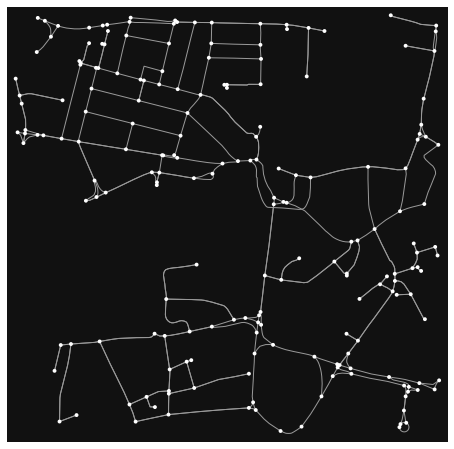

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [19]:
# plot the graph
ox.plot_graph (research_graph)

In [20]:
# check the planarity of the research graph
print("The graph is planar:",nx.check_planarity (research_graph)[0])

The graph is planar: True


In [21]:
# Project the network from WGS84 to Universal Transverse Mercator Grid System
research_graph_projected = ox.project_graph(research_graph)
# Transform the projected graph into geodataframe
research_nodes, research_edges = ox.graph_to_gdfs(research_graph_projected, edges =True, nodes = True)
research_area = research_edges.unary_union.convex_hull.area # Get sized area of the research graph
print('The area of research graph is {} square meters.'.format(research_area))

The area of research graph is 1266269.1298566803 square meters.


In [22]:
# get the basic statistical characteristics
basic_stats = ox.basic_stats(research_graph_projected, area = research_area)
basic_stats

{'n': 195,
 'm': 365,
 'k_avg': 3.7435897435897436,
 'intersection_count': 164,
 'streets_per_node_avg': 2.7897435897435896,
 'streets_per_node_counts': {0: 0, 1: 31, 2: 5, 3: 134, 4: 24, 5: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.15897435897435896,
  2: 0.02564102564102564,
  3: 0.6871794871794872,
  4: 0.12307692307692308,
  5: 0.005128205128205128},
 'edge_length_total': 24466.073,
 'edge_length_avg': 67.03033698630136,
 'street_length_total': 16692.876,
 'street_length_avg': 65.97974703557313,
 'street_segments_count': 253,
 'node_density_km': 153.99569917816018,
 'intersection_density_km': 129.51433161650394,
 'edge_density_km': 19321.384706558496,
 'street_density_km': 13182.723645714512,
 'circuity_avg': 1.2518126530571642e-05,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [23]:
# get the extended statistics
extended_stats = ox.extended_stats(research_graph_projected, ecc=False, bc=True, cc=True)
# turn them into pandas series
for key, value in extended_stats.items():
    basic_stats[key] =value
stats_def = pd.Series(basic_stats)
stats_def

n                                                                                    195
m                                                                                    365
k_avg                                                                            3.74359
intersection_count                                                                   164
streets_per_node_avg                                                             2.78974
streets_per_node_counts                         {0: 0, 1: 31, 2: 5, 3: 134, 4: 24, 5: 1}
streets_per_node_proportion            {0: 0.0, 1: 0.15897435897435896, 2: 0.02564102...
edge_length_total                                                                24466.1
edge_length_avg                                                                  67.0303
street_length_total                                                              16692.9
street_length_avg                                                                65.9797
street_segments_count

In [24]:
# the most important node
max_node = stats_def.pagerank_max_node
max_node

301285310

In [25]:
key_node = node["geometry"][max_node]
key_node = gpd.GeoDataFrame(geometry = [key_node])
print(key_node)

NameError: name 'node' is not defined

In [26]:
# Show the network
base_network = edge.plot (color = "k", zorder = 0, figsize = (12, 12), linewidth=3, alpha=0.25)
nodes_wgs.plot(ax=base_network, markersize=20, color="black", zorder=1)
# Plot the key node on the road network
key_node.plot(marker = "o", ax = base_network, markersize=150, alpha=1, color="r", zorder=2)

NameError: name 'edge' is not defined

In [28]:
# select the accidents in research area
nodes_wgs, edges_wgs = ox.graph_to_gdfs(research_graph, edges =True, nodes = True)
area_polygon = edges_wgs.unary_union.convex_hull # creat a polygon of this area
research_accidents = accidents_points[accidents_points.geometry.within (area_polygon)]
print("There are {} accidents during five years.".format(research_accidents.shape[0]))

There are 370 accidents during five years.


In [29]:
# get the locations of the points
x_values = nx.get_node_attributes (research_graph, 'x')
y_values = nx.get_node_attributes (research_graph, 'y')

# Work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list (research_graph.edges (data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString ([Point (x_values[e[0]], y_values[e[0]]), Point (x_values[e[1]], y_values[e[1]])])
graph_with_geometries[0:4]

[(643930,
  643931,
  {'osmid': 4371981,
   'oneway': True,
   'lanes': '2',
   'name': 'The Calls',
   'highway': 'tertiary',
   'maxspeed': '30 mph',
   'length': 70.05199999999999,
   'geometry': <shapely.geometry.linestring.LineString at 0x1a991d884a8>}),
 (643930,
  301688528,
  {'osmid': [5945489, 4372123],
   'oneway': True,
   'name': ['Crown Street', 'Call Lane'],
   'highway': ['unclassified', 'tertiary'],
   'length': 200.77200000000002,
   'geometry': <shapely.geometry.linestring.LineString at 0x1a991d883c8>}),
 (643931,
  643933,
  {'osmid': 38633274,
   'oneway': True,
   'lanes': '3',
   'name': 'The Calls',
   'highway': 'tertiary',
   'maxspeed': '30 mph',
   'length': 85.706,
   'geometry': <shapely.geometry.linestring.LineString at 0x1a991d88128>}),
 (643933,
  9792575,
  {'osmid': 4371979,
   'oneway': True,
   'name': 'Lower Briggate',
   'highway': 'tertiary',
   'length': 173.683,
   'geometry': <shapely.geometry.linestring.LineString at 0x1a991d88588>})]

In [30]:
# get the locations of the points
x_values = nx.get_node_attributes (research_graph, 'x')
y_values = nx.get_node_attributes (research_graph, 'y')

# Work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list (research_graph.edges (data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString ([Point (x_values[e[0]], y_values[e[0]]), Point (x_values[e[1]], y_values[e[1]])])
graph_with_geometries[0:4]
# drop the start and end nodes and construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# construct a GeoDataFrame
roads_geodataframe = gpd.GeoDataFrame(pd.DataFrame (road_lines))
accidents_points_graph = spt.Network(in_data = roads_geodataframe, extractgraph=True)
# Snap the crime points to the network
accidents_points_graph.snapobservations (research_accidents, 'accidents')

In [31]:
nodes_df, edges_df = spt.element_as_gdf (accidents_points_graph, vertices = True, arcs = True)

print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    accidents_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    accidents_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

observation 1
true coords:	(-1.5409827434473067, 53.79550835903776)
snapped coords:	(-1.5410130043053556, 53.79551576908462)


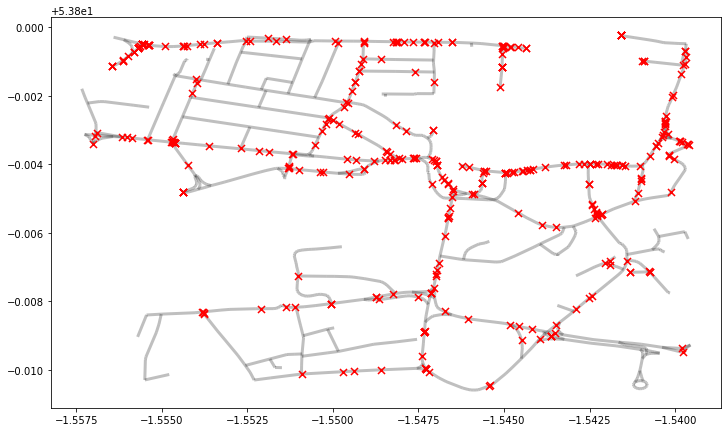

,id,geometry,comp_label
0,0,POINT (-1.54101 53.79552),0
1,1,POINT (-1.55382 53.79169),0
2,2,POINT (-1.55645 53.79887),0
3,3,POINT (-1.54433 53.79583),0
4,4,POINT (-1.55695 53.79684),0
...,...,...,...
365,365,POINT (-1.55439 53.79518),0
366,366,POINT (-1.54497 53.79576),0
367,367,POINT (-1.54834 53.79613),0
368,368,POINT (-1.54834 53.79613),0


In [32]:
# Show the network
base_network = edges_df.plot (color = "k", zorder = 0, figsize = (12, 12), linewidth=3, alpha=0.25)
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_accidents = spt.element_as_gdf (accidents_points_graph, pp_name = 'accidents', snapped = True)
# Plot these on the road network
snapped_accidents.plot (color = "r", marker = "x", markersize = 50, zorder = 1, ax = base_network)
plt.show ()
snapped_accidents

In [46]:
# compute the counts
pointpat = accidents_points_graph.pointpatterns['accidents']
counts = accidents_points_graph.count_per_link (pointpat.obs_to_arc, graph = False)

In [47]:
weights = accidents_points_graph.w_network
values = [counts[i] if i in counts else 0.0 for i in weights.neighbors] 

In [48]:
moran_accidents = esda.moran.Moran(values, weights)

(<Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.14', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.14)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

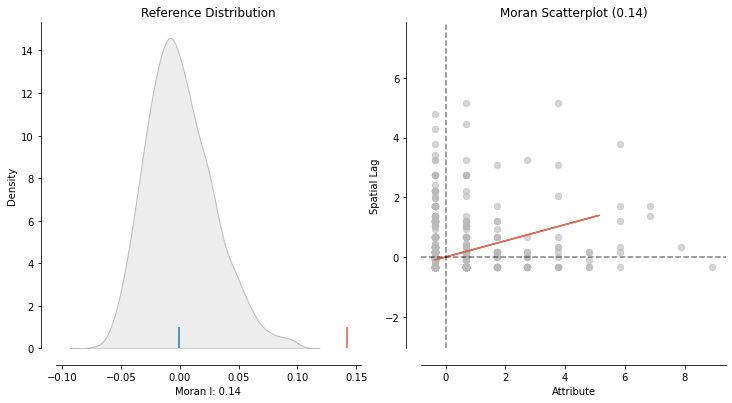

In [49]:
# compute the counts
pointpat = accidents_points_graph.pointpatterns['accidents']
counts = accidents_points_graph.count_per_link (pointpat.obs_to_arc, graph = False)
# compute the weights and values
weights = accidents_points_graph.w_network
values = [counts[i] if i in counts else 0.0 for i in weights.neighbors] 
# compute moran index
moran_accidents = esda.moran.Moran(values, weights)
# plot the moran scatterplot and reference distribution
figsize = (12,6)
plot_moran(moran_accidents, zstandard=True, figsize=figsize)

In [50]:
moran, yaxis_graph = accidents_points_graph.Moran("accidents")

AttributeError: 'Network' object has no attribute 'Moran'

In [39]:
moran.I

0.1572737380281197

In [40]:
moran.p_sim

0.001

In [81]:
moran.z_sim
print("The value of moran I is {}, with the p-value of {} and the z-score of {}.".format(moran.I, moran.p_sim, moran.z_sim))

The value of moran I is 0.1572737380281197, with the p-value of 0.001 and the z-score of 5.955102607377678.


(<Figure size 864x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.16', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.16)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

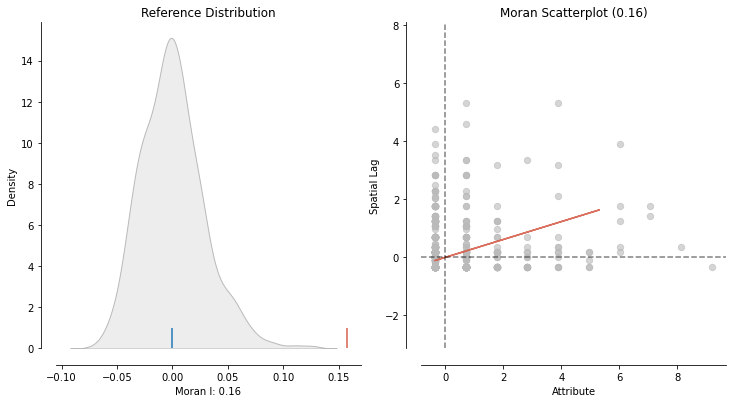

In [48]:
figsize = (12,6)
plot_moran(moran, zstandard=True, figsize=figsize)

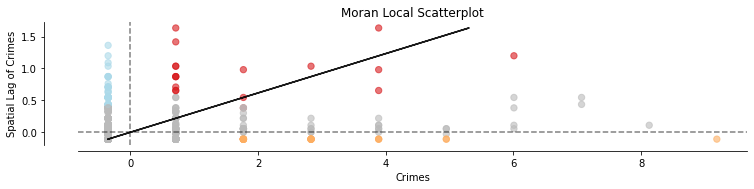

In [105]:
p = 0.05
moran_loc_ntwwn = esda.moran.Moran_Local(values, weights)
fig, ax = plt.subplots(figsize=figsize)
moran_scatterplot(moran_loc_ntwwn, p=p, aspect_equal=True, ax=ax)
ax.set(xlabel="Crimes", ylabel="Spatial Lag of Crimes");

D:\Asoftware\Anaconda\envs\cusplondon\lib\site-packages\splot\_viz_esda_mpl.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
D:\Asoftware\Anaconda\envs\cusplondon\lib\site-packages\splot\_viz_esda_mpl.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


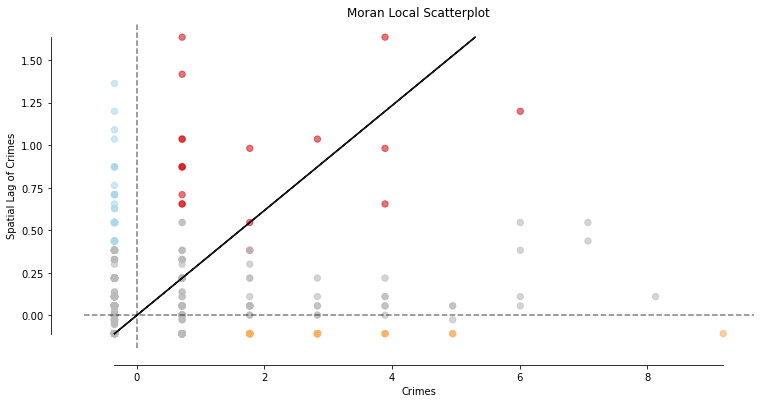

In [106]:
fig, ax = plt.subplots(figsize=figsize)
moran_scatterplot(moran_loc_ntwwn, p=p, aspect_equal=False, ax=ax)
ax.set(xlabel="Crimes", ylabel="Spatial Lag of Crimes");

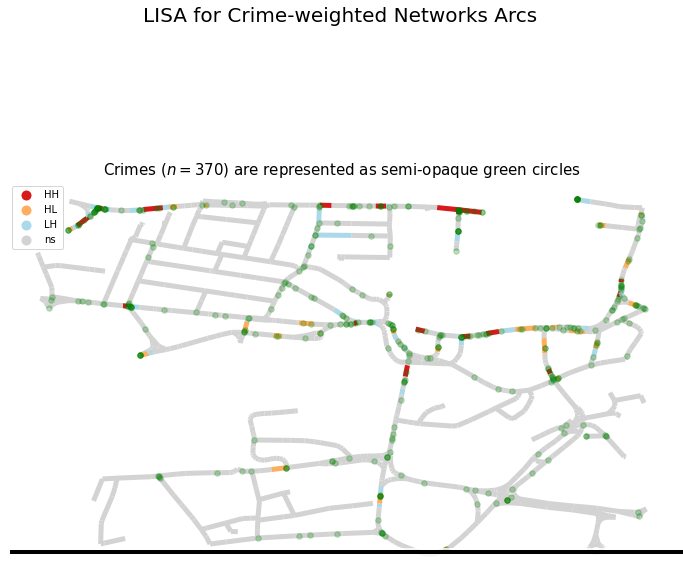

In [111]:
lisa_args = moran_loc_ntwwn, edges_df
lisa_kwds = {"p":p, "figsize":(12,12), "lw":5, "zorder":0}
f, ax = lisa_cluster(*lisa_args, **lisa_kwds)
snapped_accidents.plot(ax=ax, alpha=.25, color="g", markersize=30, zorder=1)
suptitle = "LISA for Crime-weighted Networks Arcs"
plt.suptitle(suptitle, fontsize=20, x=.51, y=.93)
subtitle = "Crimes ($n=%s$) are represented as semi-opaque green circles"
plt.title(subtitle % snapped_accidents.shape[0], fontsize=15)
sbkw = {"units":"ft", "dimension":"imperial-length", "fixed_value":1000}
sbkw.update({"location":"lower left", "box_alpha":.75})
ax.add_artist(matplotlib_scalebar.scalebar.ScaleBar(1, **sbkw));

The number of accidents happening nearer to the intersection: 212, while the number of accidents happening nearer to partway along the road: 158


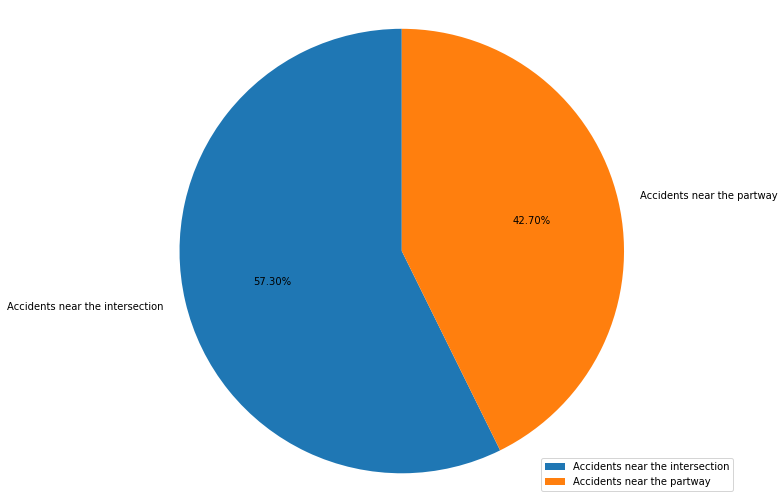

In [102]:
# compute the fraction of the road length away from the nearest intersection accidents occur
fraction_list = []
# distances betweet accident points and vertices
dist_accidents = accidents_points_graph.pointpatterns["accidents"].dist_to_vertex
for key_1,values_1 in  dist_accidents.items():
    dist = 0
    dist_right = 0
    for key_2, values_2 in values_1.items():
        dist = values_2 + dist
        dist_right = values_2 # distances between accident points and right intersections
    dist_left = dist - dist_right # distances between accident points and left intersections
    min_dist = min([dist_left, dist_right]) # distances between accident points and nearest intersections
    fraction = min_dist / dist 
    fraction_list.append(fraction)
# Compute the number of accidents happening nearer to the intersection
accs_near_intersection = [x for x in fraction_list if x < 0.25]
# Compute the number of accidents happening on the open street
accs_along_road = [x for x in fraction_list if x >= 0.25]
print("The number of accidents happening nearer to the intersection: {}, while the number of accidents happening nearer to partway along the road: {}".format(len(accs_near_intersection), len(accs_along_road)))

plt.figure(figsize=(12,9))
data = [len(accs_near_intersection), len(accs_along_road)]
label_name = ['Accidents near the intersection','Accidents near the partway']
plt.pie(data,labels=label_name, labeldistance = 1.1,autopct='%1.2f%%',startangle=90)
plt.axis('equal')
plt.legend()